### Imports

In [1]:
import time
import wandb
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier,  DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

import warnings
warnings.filterwarnings('ignore')

### Utils

#### Variables

In [2]:
wine_dataset_path = "./Datasets/WineQT.csv"
housing_dataset_path = "./Datasets/HousingData.csv"

random_state = 42
mlp = False

#### Base Models

In [3]:
class MLP_Regression:
    def __init__(self, input_size, hidden_layers, output_size=1, learning_rate=0.01, activation='sigmoid', optimizer='sgd', print_every=None, wandb_log=False, max_epochs=10, batch_size=32):
        assert activation.lower() in ['sigmoid', 'relu', 'tanh'], "Activation function must be either 'sigmoid', 'relu' or 'tanh'"
        assert optimizer.lower() in ['sgd', 'bgd', 'mbgd'], "Optimizer must be either 'sgd', 'bgd' or 'mbgd'"
        assert input_size > 0, "Input size must be greater than 0"
        assert output_size > 0, "Output size must be greater than 0"
        assert learning_rate > 0, "Learning rate must be greater than 0"
        assert type(hidden_layers) == list and len(hidden_layers) > 0, "Hidden layers must be a list of size greater than 0"

        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.activation_func = self._get_activation_func(activation)
        self.optimizer_func = self._get_optimizer_func(optimizer)
        self.weights, self.biases = self._initialize_weights_and_biases()

        self.wandb_log = wandb_log
        self.print_every = print_every
        self.max_epochs = max_epochs
        self.batch_size = batch_size

    # Activation functions
    def _get_activation_func(self, activation):
        if activation == "sigmoid":
            return self._sigmoid
        elif activation == "tanh":
            return self._tanh
        elif activation == "relu":
            return self._relu
        else:
            raise ValueError(f"Activation function '{activation}' not supported.")

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _tanh(self, x):
        return np.tanh(x)

    def _relu(self, x):
        return np.maximum(0, x)

    # Activation derivative
    def _activation_derivative(self, Z):
        if self.activation_func == self._sigmoid:
            return self._sigmoid_derivative(Z)
        elif self.activation_func == self._tanh:
            return self._tanh_derivative(Z)
        elif self.activation_func == self._relu:
            return self._relu_derivative(Z)
        else:
            raise ValueError(
                f"Activation function '{self.activation_func}' not supported."
            )

    def _sigmoid_derivative(self, Z):
        return self._sigmoid(Z) * (1 - self._sigmoid(Z))

    def _tanh_derivative(self, Z):
        return 1 - np.square(self._tanh(Z))

    def _relu_derivative(self, Z):
        return np.where(Z > 0, 1, 0)

    # Optimizers
    def _get_optimizer_func(self, optimizer):
        if optimizer == "sgd":
            return self._sgd
        elif optimizer == "bgd":
            return self._bgd
        elif optimizer == "mbgd":
            return self._mbgd
        else:
            raise ValueError(f"Optimizer '{optimizer}' not supported.")

    def _sgd(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads["dW"][i]
            self.biases[i] -= self.learning_rate * grads["db"][i]

    def _bgd(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads["dW"][i] / self.input_size
            self.biases[i] -= self.learning_rate * grads["db"][i] / self.input_size

    def _mbgd(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= (
                self.learning_rate * grads["dW"][i] / grads["dW"][i].shape[1]
            )
            self.biases[i] -= (
                self.learning_rate * grads["db"][i] / grads["db"][i].shape[1]
            )

    # Initialize weights and biases
    def _initialize_weights_and_biases(self):
        num_layers = len(self.hidden_layers)
        weights = []
        biases = []

        if num_layers == 0:
            w = np.random.randn(self.input_size, self.output_size)
            b = np.zeros((1, self.output_size))
            weights.append(w)
            biases.append(b)
            return weights, biases

        # Using Github Copilot
        for i in range(num_layers + 1):
            if i == 0:
                w = 0.01 * np.random.randn(self.input_size, self.hidden_layers[0])
            elif i == num_layers:
                w = 0.01 * np.random.randn(self.hidden_layers[-1], self.output_size)
            else:
                w = 0.01 * np.random.randn(
                    self.hidden_layers[i - 1], self.hidden_layers[i]
                )

            b = np.zeros((1, w.shape[1]))
            weights.append(w)
            biases.append(b)

        return weights, biases

    # Forward propagation
    def _forward_propagation(self, X):
        num_layers = len(self.weights)
        A = X
        caches = []

        for i in range(num_layers):
            W = self.weights[i]
            b = self.biases[i]

            Z = np.dot(A, W) + b

            if Z.shape[1] == 1:
                Z = Z.reshape(-1)
            caches.append((A, W, b, Z))
            # print("Forward", A.shape, W.shape, b.shape, Z.shape)

            A = self.activation_func(Z)

        if len(A.shape) == 1:
            A = A.reshape(-1)
        return A, caches

    # Backward propagation
    def _backward_propagation(self, A, Y, caches):
        num_samples = A.shape[0]
        num_layers = len(self.weights)
        grads = {"dW": [], "db": []}

        delta = A - Y
        # print(delta.shape, A.shape, Y.shape)

        for i in reversed(range(num_layers)):
            A, W, _, Z = caches[i]
            # print("A", A.shape, "W", W.shape, "Z", Z.shape)

            dZ = np.multiply(delta, self._activation_derivative(Z))
            if dZ.ndim == 1:
                dZ = dZ.reshape((dZ.shape[0], 1))
            # print("dZ", dZ.shape)
            dW = np.dot(A.T, dZ)
            # print("dW", dW.shape)
            db = np.sum(dZ, axis=0, keepdims=True)
            # print("db", db.shape)

            delta = np.dot(dZ, W.T)
            # print("delta", delta.shape)

            if len(dW.shape) == 1:
                dW = dW.reshape(-1, 1)

            grads["dW"].append(dW)
            grads["db"].append(db)

        grads["dW"].reverse()
        grads["db"].reverse()

        return grads

    # Calculate cost
    def _calculate_cost(self, A, Y):
        # print(A.shape, Y.shape)
        mse = np.mean(np.square(A - Y))
        rmse = np.sqrt(mse)
        r_squred = 1 - (np.sum(np.square(Y - A)) / np.sum(np.square(Y - np.mean(Y))))
        return mse, rmse, r_squred

    # Predict
    def predict(self, X):
        A, _ = self._forward_propagation(X)
        return A
    
    # Evaluate
    def evaluate(self, X, Y):
        A = self.predict(X)
        mse, rmse, r_squared = self._calculate_cost(A, Y)
        return mse, rmse, r_squared

    def fit(self, X, Y, X_validation=None, y_validation=None):
        return self.train(X, Y, X_validation, y_validation)

    # Train the model
    def train(self, X, Y, X_validation=None, y_validation=None):
        num_samples = X.shape[0]
        costs = []
        max_epochs = self.max_epochs
        batch_size = self.batch_size

        for i in range(max_epochs):
            if self.optimizer == "bgd":
                batch_size = num_samples
                num_batches = 1
            elif self.optimizer == "sgd":
                batch_size = 1
                num_batches = num_samples
            elif self.optimizer == "mbgd":
                num_batches = num_samples // batch_size
            else:
                raise ValueError(f"Optimizer '{self.optimizer}' not supported.")

            for j in range(num_batches):
                start = j * batch_size
                end = start + batch_size

                A, caches = self._forward_propagation(X[start:end])
                grads = self._backward_propagation(A, Y[start:end], caches)
                self.optimizer_func(grads)

            A = self.predict(X)
            mse, rmse, r_squared = self._calculate_cost(A, Y)
            costs.append(mse)

            data_to_log = {"epoch": i + 1, "train_loss": mse}

            # Calculate validation loss
            if X_validation is not None and y_validation is not None:
                A = self.predict(X_validation)
                val_loss_mse, val_loss_rmse, val_loss_r_squared = self._calculate_cost(A, y_validation)
                data_to_log["val_loss"] = val_loss_mse

            if self.wandb_log:
                wandb.log(data_to_log)

            if self.print_every and (i + 1) % self.print_every == 0:
                print(f"Cost after {i+1} epochs: {mse}")

        return costs

In [4]:
class MLP_Classifier:
    def __init__(self, input_size, hidden_layers, num_classes=11, learning_rate=0.01, activation='sigmoid', optimizer='sgd', wandb_log=False, print_every=None, max_epochs=10, batch_size=32):
        assert activation.lower() in ['sigmoid', 'relu', 'tanh'], "Activation function must be either 'sigmoid', 'relu' or 'tanh'"
        assert optimizer.lower() in ['sgd', 'bgd', 'mbgd'], "Optimizer must be either 'sgd', 'bgd' or 'mbgd'"
        assert input_size > 0, "Input size must be greater than 0"
        assert num_classes > 0, "Output size must be greater than 0"
        assert learning_rate > 0, "Learning rate must be greater than 0"
        assert type(hidden_layers) == list and len(hidden_layers) > 0, "Hidden layers must be a list of size greater than 0"

        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = num_classes
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.activation_func = self._get_activation_func(activation)
        self.optimizer_func = self._get_optimizer_func(optimizer)
        self.weights, self.biases = self._initialize_weights_and_biases()

        self.wandb_log = wandb_log
        self.print_every = print_every
        self.max_epochs = max_epochs
        self.batch_size = batch_size
    
    # Activation functions
    def _get_activation_func(self, activation):
        if activation == 'sigmoid':
            return self._sigmoid
        elif activation == 'tanh':
            return self._tanh
        elif activation == 'relu':
            return self._relu
        else:
            raise ValueError(f"Activation function '{activation}' not supported.")

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _tanh(self, x):
        return np.tanh(x)

    def _relu(self, x):
        return np.maximum(0, x)
    
    # Activation derivative
    def _activation_derivative(self, Z):
        if self.activation_func == self._sigmoid:
            return self._sigmoid_derivative(Z)
        elif self.activation_func == self._tanh:
            return self._tanh_derivative(Z)
        elif self.activation_func == self._relu:
            return self._relu_derivative(Z)
        else:
            raise ValueError(f"Activation function '{self.activation_func}' not supported.")
    
    def _sigmoid_derivative(self, Z):
        return self._sigmoid(Z) * (1 - self._sigmoid(Z))
    
    def _tanh_derivative(self, Z):
        return 1 - np.square(self._tanh(Z))
    
    def _relu_derivative(self, Z):
        return np.where(Z > 0, 1, 0)
    
    ## Optimizers
    def _get_optimizer_func(self, optimizer):
        if optimizer == 'sgd':
            return self._sgd
        elif optimizer == 'bgd':
            return self._bgd
        elif optimizer == 'mbgd':
            return self._mbgd
        else:
            raise ValueError(f"Optimizer '{optimizer}' not supported.")
    
    def _sgd(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= (self.learning_rate * grads['dW'][i])
            self.biases[i] -= (self.learning_rate * grads['db'][i])
    
    def _bgd(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= (self.learning_rate * grads['dW'][i] / self.input_size)
            self.biases[i] -= (self.learning_rate * grads['db'][i] / self.input_size)

    def _mbgd(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= (self.learning_rate * grads['dW'][i] / grads['dW'][i].shape[1])
            self.biases[i] -= (self.learning_rate * grads['db'][i] / grads['db'][i].shape[1])
    
    # Initialize weights and biases
    def _initialize_weights_and_biases(self):
        num_layers = len(self.hidden_layers)
        weights = []
        biases = []

        if num_layers == 0:
            w = np.random.randn(self.input_size, self.output_size)
            b = np.zeros((1, self.output_size))
            weights.append(w)
            biases.append(b)
            return weights, biases
        
        # Using Github Copilot
        for i in range(num_layers + 1):
            if i == 0:
                w = np.random.randn(self.input_size, self.hidden_layers[0])
            elif i == num_layers:
                w = np.random.randn(self.hidden_layers[-1], self.output_size)
            else:
                w = np.random.randn(self.hidden_layers[i - 1], self.hidden_layers[i])
            
            b = np.zeros((1, w.shape[1]))
            weights.append(w)
            biases.append(b)

        return weights, biases
    
    # Forward propagation
    def _forward_propagation(self, X):
        num_layers = len(self.weights)
        A = X
        caches = []
        
        for i in range(num_layers):
            W = self.weights[i]
            b = self.biases[i]
            Z = np.dot(A, W) + b
            
            if Z.shape[1] == 1:
                Z = Z.reshape(-1)
            caches.append((A, W, b, Z))
            # print(A.shape, W.shape, b.shape, Z.shape)

            A = self.activation_func(Z)
        
        if len(A.shape) == 1:
            A = A.reshape(-1)
        return A, caches

    # Backward propagation
    def _backward_propagation(self, A, Y, caches):
        num_samples = A.shape[0]
        num_layers = len(self.weights)
        grads = {'dW': [], 'db': []}

        delta = A-Y
        # print(delta.shape, A.shape, Y.shape)

        for i in reversed(range(num_layers)):
            A, W, _, Z = caches[i]
            # print("A", A.shape, "W", W.shape, "Z", Z.shape)
            
            dZ = np.multiply(delta, self._activation_derivative(Z))
            if dZ.ndim == 1:
                dZ = dZ.reshape((dZ.shape[0], 1))
            # print("dZ", dZ.shape)
            dW = np.dot(A.T, dZ)
            # print("dW", dW.shape)
            db = np.sum(dZ, axis=0, keepdims=True)
            # print("db", db.shape)

            delta = np.dot(dZ, W.T)
            # print("delta", delta.shape)

            if len(dW.shape) == 1:
                dW = dW.reshape(-1, 1)

            grads['dW'].append(dW)
            grads['db'].append(db)
        
        grads['dW'].reverse()
        grads['db'].reverse()

        return grads
    
    # Calculate cost
    def _calculate_cost(self, A, Y):
        cost = np.mean(np.not_equal(A, Y))
        return cost

    # Predict
    def predict(self, X, return_prob=False):
        A, _ = self._forward_propagation(X)

        # Apply a softmax to get probabilities & then getting the h9ghest probability
        prob = np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True)

        A = np.argmax(prob,axis=1)

        if return_prob:
            return A, np.max(prob, axis=1)
        return A

    def fit(self, X, Y, X_validation=None, y_validation=None):
        return self.train(X, Y, X_validation, y_validation)

    # Train the model
    def train(self, X, Y, X_validation=None, y_validation=None):
        num_samples = X.shape[0]
        costs = []
        max_epochs = self.max_epochs
        batch_size = self.batch_size

        enc = OneHotEncoder().fit(np.array([[i,] for i in range(self.output_size)]))
        y_new = enc.transform(Y.reshape(-1, 1)).toarray()
        
        for i in range(max_epochs):
            if self.optimizer == "bgd":
                batch_size = num_samples
                num_batches = 1
            elif self.optimizer == "sgd":
                batch_size = 1
                num_batches = num_samples
            elif self.optimizer == "mbgd":
                num_batches = num_samples // batch_size
            else:
                raise ValueError(f"Optimizer '{self.optimizer}' not supported.")

            for j in range(num_batches):
                start = j * batch_size
                end = start + batch_size
                
                A, caches = self._forward_propagation(X[start:end])
                grads = self._backward_propagation(A, y_new[start:end], caches)
                self.optimizer_func(grads)
            
            A = self.predict(X)
            cost = self._calculate_cost(A, Y)
            costs.append(cost)

            data_to_log = {
                "epoch": i + 1,
                "train_loss": cost
            }

            # Calculate validation loss
            if X_validation is not None and y_validation is not None:
                A = self.predict(X_validation)
                val_loss = self._calculate_cost(A, y_validation)
                data_to_log["val_loss"] = val_loss

            if self.wandb_log:
                wandb.log(data_to_log)
            
            if self.print_every and (i+1) % self.print_every == 0:
                print(f"Cost after {i+1} epochs: {cost}")
        
        return costs

In [5]:
class Logistic_Regression:
    def __init__(self, num_classes=10, learning_rate=0.01, num_epochs=1000, print_every=None, wandb_log=False):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.classes = range(num_classes)
        self.weights = [None,] * num_classes
        self.bias = [None,] * num_classes
        self.print_every = print_every
        self.wandb_log = wandb_log
        self.num_classes = num_classes

        self.val_acc = []
        self.train_acc = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=0)
    
    def loss(self, y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred)) / len(y_true)
    
    def fit(self, X, y, X_val=None, y_val=None):
        num_samples, num_features = X.shape
        self.weights = np.zeros((num_features, self.num_classes))
        self.bias = np.zeros(self.num_classes)
        train_loss = []
        self.val_acc = []
        self.train_acc = []

        enc = OneHotEncoder().fit(np.array([[i,] for i in range(self.num_classes)]))
        y_new = enc.transform(y.reshape(-1, 1)).toarray()
        
        for i in range(self.num_epochs):
            z = self.sigmoid(np.dot(X, self.weights) + self.bias[np.newaxis, :])
            y_predicted = self.softmax(z)

            dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y_new))
            db = (1 / num_samples) * np.sum(y_predicted - y_new)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            loss = self.loss(y_new, y_predicted)
            train_loss.append(loss)

            y_predicted_train = self.predict(X)
            self.train_acc.append(self.accuracy(y, y_predicted_train))

            if X_val is not None and y_val is not None:
                y_predicted_val = self.predict(X_val)
                self.val_acc.append(self.accuracy(y_val, y_predicted_val))

            if self.print_every and (i+1) % self.print_every == 0:
                print(f'Epoch {i+1} loss: {loss:.4f}')
                if X_val is not None and y_val is not None:
                    print(f'Val Acc: {self.val_acc[-1]*100:.2f} Train Acc: {self.train_acc[-1]*100:.2f}')
                else:
                    print(f'Train Acc: {self.train_acc[-1]*100:.2f}')

            if self.wandb_log:
                wandb.log({"epoch": i+1,"train_loss": loss, "val_acc": self.val_acc[-1], "train_acc": self.train_acc[-1]})
        
        return train_loss
    
    def predict(self, X, return_prob=False):
        y_predicted = self.softmax(np.dot(X, self.weights) + self.bias[np.newaxis, :])
        y_predicted_cls = np.argmax(y_predicted, axis=1)
        if return_prob:
            return y_predicted_cls, np.max(y_predicted, axis=1)
        return y_predicted_cls
    
    def accuracy(self, y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        accuracy = self.accuracy(y, y_pred)
        return accuracy
    
    def plot_loss(self, train_loss):
        plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

    def plot_acc(self):
        plt.plot(range(1, len(self.val_acc) + 1), self.val_acc, label='Validation Accuracy')
        plt.plot(range(1, len(self.train_acc) + 1), self.train_acc, label='Train Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

In [6]:
class Linear_Regression:
    def __init__(self, learning_rate=0.01, num_epochs=1000, print_every=None, wandb_log=False):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.weights = None
        self.bias = None
        self.print_every = print_every
        self.wandb_log = wandb_log

        self.train_loss = []

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0
        self.train_loss = []

        for i in range(self.num_epochs):
            y_predicted = np.dot(X, self.weights) + self.bias

            error = y_predicted - y
            dw = (1 / num_samples) * np.dot(X.T, error)
            db = (1 / num_samples) * np.sum(error)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            loss = self.loss(y, y_predicted)
            self.train_loss.append(loss)

            if self.print_every and (i+1) % self.print_every == 0:
                print(f'Epoch {i+1} loss: {loss:.4f}')

            if self.wandb_log:
                wandb.log({"epoch": i+1,"train_loss": loss})
        
        return self.train_loss
    
    def predict(self, X):
        y_predicted = np.dot(X, self.weights) + self.bias
        return y_predicted
    
    def loss(self, y_true, y_pred):
        return np.mean(np.square(y_true - y_pred))
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        loss = self.loss(y, y_pred)
        return loss
    
    def plot_loss(self):
        plt.plot(range(1, len(self.train_loss) + 1), self.train_loss, label='Training Loss')
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

#### Ensemble Models

In [7]:
class Bagging:
    def __init__(self, base_estimator, best_params, n_estimators=10, fraction=0.15, bootstrap=True, hard_voting=True, classification=True):
        assert fraction > 0 and fraction <= 1, "Fraction must be between 0 and 1"
        assert n_estimators > 0, "Number of estimators must be greater than 0"

        self.base_estimator = base_estimator
        self.best_params = best_params
        self.n_estimators = n_estimators
        self.fraction = fraction
        self.bootstrap = bootstrap
        self.hard_voting = hard_voting
        self.classification = classification

        self.estimators = []
        self.estimators_weights = []

    def _bootstrap(self, X, y, fraction, n):
        data_array = []
        for i in range(n):
            indices = np.random.choice(range(X.shape[0]), size=int(X.shape[0] * fraction))
            data_array.append((X[indices], y[indices]))
        return data_array
    
    def _random_sampling(self, X, y, fraction, n):
        data_array = []
        permuted_index = np.random.permutation(len(X))
        X = X[permuted_index]
        y = y[permuted_index]
        num_samples = int(X.shape[0] * fraction)
        for i in range(num_samples, X.shape[0], num_samples):
            data_array.append((X[i-num_samples: i], y[i-num_samples: i]))
        return data_array[:n]
        
    def fit(self, X, y, X_val, y_val):
        self.estimators_weights = []
        self.estimators = []

        if self.bootstrap==False:
            assert self.fraction * self.n_estimators <= 1
        if self.bootstrap:
            Samples = self._bootstrap(X, y, self.fraction, self.n_estimators)
        else:
            Samples = self._random_sampling(X, y, self.fraction, self.n_estimators)

        for i in range(self.n_estimators):
            X_sample, y_sample = Samples[i]
            
            estimator = self.base_estimator(**self.best_params)
            estimator.fit(X_sample, y_sample)
            self.estimators.append(estimator)

            if self.hard_voting:
                self.estimators_weights.append(1)
            else:
                y_pred = estimator.predict(X_val)
                if self.classification:
                    self.estimators_weights.append(accuracy_score(y_val, y_pred))
                else:
                    self.estimators_weights.append(r2_score(y_val, y_pred))

    def predict(self, X):
        predictions = []
        probs = np.zeros((X.shape[0], self.n_estimators))
        for i, estimator in enumerate(self.estimators):
            if self.classification:
                if estimator.__class__.__name__ == "DecisionTreeClassifier":
                    prediction, prob = estimator.predict(X), [1,]*X.shape[0]
                else:
                    prediction, prob = estimator.predict(X, return_prob=True)
                predictions.append(prediction)
                probs[:, i] = prob
            else:
                predictions.append(estimator.predict(X))
        predictions = np.array(predictions).T

        if self.classification:
            final_predictions = []
            for i, pred in enumerate(predictions):
                final_predictions.append(np.argmax(np.bincount(pred, weights=probs[i, :])))
            return np.array(final_predictions)
        else:
            if self.hard_voting:
                return np.mean(predictions, axis=1)
            else:
                return np.dot(predictions, self.estimators_weights) / np.sum(self.estimators_weights)

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        if self.classification:
            return accuracy_score(y, y_pred)
        else:
            return r2_score(y, y_pred)

In [8]:
class Stacking:
    def __init__(self, base_estimators, final_estimator, final_estimator_params, method='stacking', classification=True, n_fold = 5):
        assert method.lower() in ['stacking', 'blending'], "Method must be either 'stacking' or 'blending'"

        self.base_estimators = base_estimators
        self.final_estimator = final_estimator(**final_estimator_params)
        self.method = method
        self.classification = classification
        self.n_fold = n_fold
    
    def fit(self, X, y):
        kf = KFold(n_splits=self.n_fold)
        X_new = X.copy()
        no_estimators = len(self.base_estimators)

        if self.method == 'stacking':
            new_column = np.zeros((X.shape[0], no_estimators))
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                for index, estimator in enumerate(self.base_estimators):
                    estimator.fit(X_train, y_train)
                    y_pred = estimator.predict(X_test)
                    new_column[test_index, index] = y_pred
            
            for index, estimator in enumerate(self.base_estimators):
                estimator.fit(X, y)
                
            X_new = np.column_stack((X_new, new_column))
            
            self.final_estimator.fit(X_new[:,-no_estimators:], y)
        
        elif self.method == 'blending':
            new_column = np.zeros((X.shape[0], no_estimators))
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                for index, estimator in enumerate(self.base_estimators):
                    estimator.fit(X_train, y_train)
                    y_pred = estimator.predict(X_test)
                    new_column[test_index, index] = y_pred
                break
                
            X_new = np.column_stack((X_new, new_column))
            
            self.final_estimator.fit(X_new[test_index, :], y_test)

    def predict(self, X):
        X_new = X.copy()
        no_estimators = len(self.base_estimators)

        if self.method == 'stacking':
            new_column = np.zeros((X.shape[0], no_estimators))
            for index, estimator in enumerate(self.base_estimators):
                y_pred = estimator.predict(X)
                new_column[:, index] = y_pred
            
            X_new = np.column_stack((X_new, new_column))
            return self.final_estimator.predict(X_new[:,-no_estimators:])

        elif self.method == 'blending':
            new_column = np.zeros((X.shape[0], no_estimators))
            for index, estimator in enumerate(self.base_estimators):
                y_pred = estimator.predict(X)
                new_column[:, index] = y_pred
            
            X_new = np.column_stack((X_new, new_column))
            return self.final_estimator.predict(X_new)

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        try:
            if self.classification:
                return accuracy_score(y, y_pred)
            else:
                return r2_score(y, y_pred)
        except:
            return 0
                
        

In [9]:
class RandomForest:
    def __init__(self, best_params, n_estimators=10, classification=True):
        if classification:
            self.bagging = Bagging(DecisionTreeClassifier, best_params, n_estimators=n_estimators, classification=classification, hard_voting=True, fraction=1.0)
        else:
            self.bagging = Bagging(DecisionTreeRegressor, best_params, n_estimators=n_estimators, classification=classification, hard_voting=False, fraction=1.0)
    
    def fit(self, X, y, X_val, y_val):
        self.bagging.fit(X, y, X_val, y_val)
    
    def predict(self, X):
        return self.bagging.predict(X)
    
    def evaluate(self, X, y):
        return self.bagging.evaluate(X, y)

In [57]:
class AdaBoostClassifier: # Using Basic AdaBoost Algorithm
    def __init__(self, T=10, best_params=None):
        self.T = T
        self.best_params = best_params
    
    def fit(self, X_train, y_train):
        self.N, self.D = X_train.shape
        self.X_train = X_train
        self.y_train = np.array([1 if y == 1 else -1 for y in y_train])
        
        self.weights = [1/self.N,] * self.N
        self.trees = []
        self.alphas = []
        self.yhats = np.empty((self.N, self.T))
        
        for t in range(self.T):
            self.T_t = DecisionTreeClassifier(**self.best_params)
            self.T_t.fit(self.X_train, self.y_train, self.weights)
            self.yhat_t = self.T_t.predict(self.X_train)

            self.epsilon_t = sum(self.weights*(self.yhat_t != self.y_train))/sum(self.weights)
            self.alpha_t = np.log((1-self.epsilon_t)/self.epsilon_t)
            self.weights = np.array([w*(1-self.epsilon_t)/self.epsilon_t if self.yhat_t[i] != self.y_train[i]
                                    else w for i, w in enumerate(self.weights)])
            
            self.trees.append(self.T_t)
            self.alphas.append(self.alpha_t)
            self.yhats[:,t] = self.yhat_t 
            
        self.yhat = np.sign(np.dot(self.yhats, self.alphas))
        self.yhat[self.yhat <= 0] = 0
        return self.yhat
        
    def predict(self, X_test):
        yhats = np.zeros(len(X_test))
        for t, tree in enumerate(self.trees):
            yhats_tree = tree.predict(X_test)
            yhats += yhats_tree*self.alphas[t]
        yhats = np.sign(yhats)
        yhats[yhats <= 0] = 0
        return yhats

    def evaluate(self, X_test, y_test):
        yhat = self.predict(X_test)
        return accuracy_score(y_test, yhat)
        

In [63]:
class AdaBoostRegressor: # Using Adaboost R2 Algotithm
    def __init__(self, T=10, best_params=None, random_state = None):
        self.T = T
        self.best_params = best_params
        np.random.seed(random_state)
    
    def fit(self, X_train, y_train):
        self.y_train = y_train
        self.X_train = X_train
        self.N, self.D = X_train.shape
        self.weights = np.repeat(1/self.N, self.N)
        
        self.trees = []    
        self.fitted_values = np.empty((self.N, self.T))
        self.betas = []
        for t in range(self.T):
            bootstrap_indices = np.random.choice(np.arange(self.N), size = self.N, replace = True, p = self.weights)
            bootstrap_X = self.X_train[bootstrap_indices]
            bootstrap_y = self.y_train[bootstrap_indices]
            tree = DecisionTreeRegressor(**self.best_params)
            tree.fit(bootstrap_X, bootstrap_y)
            self.trees.append(tree)
            yhat = tree.predict(X_train)
            self.fitted_values[:,t] = yhat
            
            ## Calculate observation errors
            abs_errors_t = np.abs(self.y_train - yhat)
            D_t = np.max(abs_errors_t)
            L_ts = abs_errors_t/D_t
            
            ## Calculate model error (and possibly break)
            Lbar_t = np.sum(self.weights*L_ts)
            if Lbar_t >= 0.5:
                self.T = t - 1
                self.fitted_values = self.fitted_values[:,:t-1]
                self.trees = self.trees[:t-1]
                break
            
            ## Calculate and record beta 
            beta_t = Lbar_t/(1 - Lbar_t)
            self.betas.append(beta_t)
            
            ## Reweight
            Z_t = np.sum(self.weights*beta_t**(1-L_ts))
            self.weights *= beta_t**(1-L_ts)/Z_t
            
        self.model_weights = np.log(1/np.array(self.betas))
        self.y_train_hat = np.array([self.weighted_median(self.fitted_values[n], self.model_weights) for n in range(self.N)])

    def weighted_median(self, values, weights):
        sorted_indices = values.argsort()
        values = values[sorted_indices]
        weights = weights[sorted_indices]
        weights_cumulative_sum = weights.cumsum()
        median_weight = np.argmax(weights_cumulative_sum >= sum(weights)/2)
        return values[median_weight]
        
    def predict(self, X_test):
        N_test = len(X_test)
        fitted_values = np.empty((N_test, self.T))
        for t, tree in enumerate(self.trees):
            fitted_values[:,t] = tree.predict(X_test)
        return np.array([self.weighted_median(fitted_values[n], self.model_weights) for n in range(N_test)]) 
        
    def evaluate(self, X_test, y_test):
        yhat = self.predict(X_test)
        return r2_score(y_test, yhat)

#### Functions

In [11]:
def evaluate_all_bagging_models(n_estimators, fraction, bootstrap, hard_voting, mlp=True):
    # Bagging with DecisionTreeClassifier
    bagging_dt_classifier = Bagging(
        DecisionTreeClassifier, best_params_dt_classifier,
        n_estimators=n_estimators, fraction=fraction,
        bootstrap=bootstrap, hard_voting=hard_voting,
        classification=True
    )
    bagging_dt_classifier.fit(wine_X_train, wine_y_train, wine_X_val, wine_y_val)

    # Bagging with DecisionTreeRegressor
    bagging_dt_regressor = Bagging(
        DecisionTreeRegressor, best_params_dt_regressor,
        n_estimators=n_estimators, fraction=fraction,
        bootstrap=bootstrap, hard_voting=hard_voting,
        classification=False
    )
    bagging_dt_regressor.fit(housing_X_train, housing_y_train, housing_X_val, housing_y_val)

    # Bagging with Logistic Regression
    bagging_logreg = Bagging(
        Logistic_Regression, best_params_logistic,
        n_estimators=n_estimators, fraction=fraction,
        bootstrap=bootstrap, hard_voting=hard_voting,
        classification=True
    )
    bagging_logreg.fit(wine_X_train, wine_y_train, wine_X_val, wine_y_val)

    # Bagging with Linear Regression
    bagging_linreg = Bagging(
        Linear_Regression, best_params_linreg,
        n_estimators=n_estimators, fraction=fraction,
        bootstrap=bootstrap, hard_voting=hard_voting,
        classification=False
    )
    bagging_linreg.fit(housing_X_train, housing_y_train, housing_X_val, housing_y_val)

    if mlp:
        # Bagging with MLP Classifier
        bagging_mlp_classifier = Bagging(
            MLP_Classifier, best_params_mlp_classifier,
            n_estimators=n_estimators, fraction=fraction,
            bootstrap=bootstrap, hard_voting=hard_voting,
            classification=True
        )
        bagging_mlp_classifier.fit(wine_X_train, wine_y_train, wine_X_val, wine_y_val)

        # Bagging with MLP Regressor
        bagging_mlp_regressor = Bagging(
            MLP_Regression, best_params_mlp_regressor,
            n_estimators=n_estimators, fraction=fraction,
            bootstrap=bootstrap, hard_voting=hard_voting,
            classification=False
        )
        bagging_mlp_regressor.fit(housing_X_train, housing_y_train, housing_X_val, housing_y_val)

    # Evaluate all models
    bagging_dt_classifier_acc = bagging_dt_classifier.evaluate(wine_X_test, wine_y_test)
    bagging_dt_regressor_acc = bagging_dt_regressor.evaluate(housing_X_test, housing_y_test)
    bagging_logreg_acc = bagging_logreg.evaluate(wine_X_test, wine_y_test)
    bagging_linreg_acc = bagging_linreg.evaluate(housing_X_test, housing_y_test)
    if mlp:
        bagging_mlp_classifier_acc = bagging_mlp_classifier.evaluate(wine_X_test, wine_y_test)
        bagging_mlp_regressor_acc = bagging_mlp_regressor.evaluate(housing_X_test, housing_y_test)
    
    if not mlp:
        return {
            "bagging_dt_classifier": bagging_dt_classifier_acc,
            "bagging_dt_regressor": bagging_dt_regressor_acc,
            "bagging_logreg": bagging_logreg_acc,
            "bagging_linreg": bagging_linreg_acc,
        }
    
    return {
        "bagging_dt_classifier": bagging_dt_classifier_acc,
        "bagging_dt_regressor": bagging_dt_regressor_acc,
        "bagging_logreg": bagging_logreg_acc,
        "bagging_linreg": bagging_linreg_acc,
        "bagging_mlp_classifier": bagging_mlp_classifier_acc,
        "bagging_mlp_regressor": bagging_mlp_regressor_acc,
    }

In [12]:
def plotheatmap(accuracies, title):
    df = pd.DataFrame(accuracies)
    sns.heatmap(df, annot=True, cmap='RdPu', fmt='.2f', cbar_kws={'label': 'Values'}, vmin=0.0, vmax=1.0)
    plt.xlabel('Fraction of Samples')
    plt.ylabel('Number of Estimators')
    plt.title(f'Heatmap of Accuracies for {title}')
    plt.show()

### Main Code

#### Datasets

In [13]:
wine_dataset = pd.read_csv(wine_dataset_path)
wine_dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [14]:
wine_X = wine_dataset.drop(columns=['quality']).to_numpy()
wine_y = wine_dataset['quality'].to_numpy()

wine_num_classes = 11 # 0-10

In [15]:
wine_X = StandardScaler().fit_transform(wine_X)

In [16]:
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(wine_X, wine_y, test_size=0.2, random_state=random_state)
wine_X_train, wine_X_val, wine_y_train, wine_y_val = train_test_split(wine_X_train, wine_y_train, test_size=0.25, random_state=random_state)

In [17]:
housing_dataset = pd.read_csv(housing_dataset_path)
housing_dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [18]:
housing_X = housing_dataset.drop(columns=['MEDV']).to_numpy()
housing_y = housing_dataset['MEDV'].to_numpy()

In [19]:
housing_X = StandardScaler().fit_transform(housing_X)

In [20]:
imputer = SimpleImputer(strategy='mean')
housing_X = imputer.fit_transform(housing_X)
# To fill in data

In [21]:
housing_X_train, housing_X_test, housing_y_train, housing_y_test = train_test_split(housing_X, housing_y, test_size=0.2, random_state=random_state)
housing_X_train, housing_X_val, housing_y_train, housing_y_val = train_test_split(housing_X_train, housing_y_train, test_size=0.25, random_state=random_state)

#### Models

In [22]:
dt_classifier_param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_regressor_param_grid = {
    'criterion': ['absolute_error', 'friedman_mse', 'poisson', 'squared_error'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [23]:
dt_classifier = DecisionTreeClassifier(random_state=random_state)

grid_search = GridSearchCV(dt_classifier, dt_classifier_param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(wine_X_train, wine_y_train)

dt_classifier = DecisionTreeClassifier(**grid_search.best_params_, random_state=random_state)
dt_classifier.fit(wine_X_train, wine_y_train)

best_params_dt_classifier = grid_search.best_params_
print(f"Best params: {best_params_dt_classifier}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits


Best params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}


In [24]:
dt_regressor = DecisionTreeRegressor(random_state=random_state)

grid_search = GridSearchCV(dt_regressor, dt_regressor_param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(housing_X_train, housing_y_train)

dt_regressor = DecisionTreeRegressor(**grid_search.best_params_, random_state=random_state)
dt_regressor.fit(housing_X_train, housing_y_train)

best_params_dt_regressor = grid_search.best_params_
print(f"Best params: {best_params_dt_regressor}")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best params: {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}


In [21]:
best_params_logistic = {'learning_rate': 0.001, 'num_epochs': 15} # best values from hyperparameter tuning from Assignment 3

logreg = Logistic_Regression(num_classes=wine_num_classes, learning_rate=best_params_logistic['learning_rate'], num_epochs=best_params_logistic['num_epochs'], print_every=None)
logreg.fit(wine_X_train, wine_y_train, wine_X_val, wine_y_val)

print(f"Best params: {best_params_logistic}")

Best params: {'learning_rate': 0.001, 'num_epochs': 15}


In [22]:
linear_params_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_epochs': [100, 500, 1000, 2000]
}

best_linreg = [None, None, np.inf]
for lr in linear_params_grid['learning_rate']:
    for ne in linear_params_grid['num_epochs']:
        linreg = Linear_Regression(learning_rate=lr, num_epochs=ne)
        linreg.fit(housing_X_train, housing_y_train)
        loss = linreg.evaluate(housing_X_val, housing_y_val)
        if loss < best_linreg[2]:
            best_linreg = [lr, ne, loss]

linreg = Linear_Regression(learning_rate=best_linreg[0], num_epochs=best_linreg[1])
linreg.fit(housing_X_train, housing_y_train)

best_params_linreg = {'learning_rate': best_linreg[0], 'num_epochs': best_linreg[1]}
print(f"Best params: {best_params_linreg}")

Best params: {'learning_rate': 0.1, 'num_epochs': 2000}


MLP Hyperparameters from Assignment 3

In [23]:
if mlp:
    best_params_mlp_classifier = ['sgd', 'sigmoid', [8,], 0.01, 32, 1000] # optimizer, activation, hidden_layers, lr, batch_size, max_epochs

    mlp_classifier = MLP_Classifier(input_size=wine_X_train.shape[1], hidden_layers=best_params_mlp_classifier[2], num_classes=wine_num_classes, learning_rate=best_params_mlp_classifier[3], optimizer=best_params_mlp_classifier[0], activation=best_params_mlp_classifier[1], max_epochs=best_params_mlp_classifier[5], batch_size=best_params_mlp_classifier[4])
    mlp_classifier.train(wine_X_train, wine_y_train, X_validation=wine_X_val, y_validation=wine_y_val)

    best_params_mlp_classifier = {'input_size': wine_X_train.shape[1], 'num_classes': wine_num_classes, 'optimizer': best_params_mlp_classifier[0], 'activation': best_params_mlp_classifier[1], 'hidden_layers': best_params_mlp_classifier[2], 'learning_rate': best_params_mlp_classifier[3], 'batch_size': best_params_mlp_classifier[4], 'max_epochs': best_params_mlp_classifier[5]}
    print(f"Best params: {best_params_mlp_classifier}")

Best params: {'input_size': 12, 'num_classes': 11, 'optimizer': 'sgd', 'activation': 'sigmoid', 'hidden_layers': [8], 'learning_rate': 0.01, 'batch_size': 32, 'max_epochs': 1000}


In [24]:
if mlp:
    best_params_mlp_regressor = ['sgd', 'relu', [8,], 0.001, 32, 1000] # optimizer, activation, hidden_layers, lr, batch_size, max_epochs

    mlp_regressor = MLP_Regression(input_size=housing_X_train.shape[1], hidden_layers=best_params_mlp_regressor[2], learning_rate=best_params_mlp_regressor[3], optimizer=best_params_mlp_regressor[0], activation=best_params_mlp_regressor[1], max_epochs=best_params_mlp_regressor[5], batch_size=best_params_mlp_regressor[4])
    mlp_regressor.train(housing_X_train, housing_y_train, X_validation=housing_X_val, y_validation=housing_y_val)

    best_params_mlp_regressor = {'input_size': housing_X_train.shape[1],'optimizer': best_params_mlp_regressor[0], 'activation': best_params_mlp_regressor[1], 'hidden_layers': best_params_mlp_regressor[2], 'learning_rate': best_params_mlp_regressor[3], 'batch_size': best_params_mlp_regressor[4], 'max_epochs': best_params_mlp_regressor[5]}
    print(f"Best params: {best_params_mlp_regressor}")

Best params: {'input_size': 13, 'optimizer': 'sgd', 'activation': 'relu', 'hidden_layers': [8], 'learning_rate': 0.001, 'batch_size': 32, 'max_epochs': 1000}


#### Bagging

In [25]:
# bagging_dt_classifier = Bagging(DecisionTreeClassifier, best_params_dt_classifier, n_estimators=10, fraction=0.25, bootstrap=True, hard_voting=True, classification=True)
# bagging_dt_classifier.fit(wine_X_train, wine_y_train, wine_X_val, wine_y_val)
# # bagging_dt.evaluate(wine_X_test, wine_y_test)

# bagging_dt_regressor = Bagging(DecisionTreeRegressor, best_params_dt_regressor, n_estimators=6, fraction=0.15, bootstrap=False, hard_voting=True, classification=False)
# bagging_dt_regressor.fit(housing_X_train, housing_y_train, housing_X_val, housing_y_val)
# # bagging_dt_regressor.evaluate(housing_X_test, housing_y_test)

In [26]:
# bagging_logreg = Bagging(Logistic_Regression, best_params_logistic, n_estimators=10, fraction=0.15, bootstrap=True, hard_voting=True, classification=True)
# bagging_logreg.fit(wine_X_train, wine_y_train, wine_X_val, wine_y_val)

# bagging_linreg = Bagging(Linear_Regression, best_params_linreg, n_estimators=10, fraction=0.15, bootstrap=True, hard_voting=True, classification=False)
# bagging_linreg.fit(housing_X_train, housing_y_train, housing_X_val, housing_y_val)

In [27]:
# if mlp:
    # bagging_mlp_classifier = Bagging(MLP_Classifier, best_params_mlp_classifier, n_estimators=10, fraction=0.15, bootstrap=True, hard_voting=True, classification=True)
    # bagging_mlp_classifier.fit(wine_X_train, wine_y_train, wine_X_val, wine_y_val)

    # bagging_mlp_regressor = Bagging(MLP_Regression, best_params_mlp_regressor, n_estimators=10, fraction=0.15, bootstrap=True, hard_voting=True, classification=False)
    # bagging_mlp_regressor.fit(housing_X_train, housing_y_train, housing_X_val, housing_y_val)

In [275]:
params_dict = {
    'n_estimators': [2, 5, 10, 20],
    'fraction': [0.15, 0.25, 0.5, 0.75, 1.0],
    'bootstrap': [True, False],
    'hard_voting': [True, False]
}

total_runs = len(params_dict['n_estimators']) * len(params_dict['fraction']) * len(params_dict['bootstrap']) * len(params_dict['hard_voting'])

best_params_bagging_dt_classifier = [None, None, None, None, -np.inf]
best_params_bagging_dt_regressor = [None, None, None, None, -np.inf]
best_params_bagging_logreg = [None, None, None, None, -np.inf]
best_params_bagging_linreg = [None, None, None, None, -np.inf]
best_params_bagging_mlp_classifier = [None, None, None, None, -np.inf]
best_params_bagging_mlp_regressor = [None, None, None, None, -np.inf]

accuracies_bagging_dt_classifier = dict()
accuracies_bagging_dt_regressor = dict()
accuracies_bagging_logreg = dict()
accuracies_bagging_linreg = dict()
accuracies_bagging_mlp_classifier = dict()
accuracies_bagging_mlp_regressor = dict()

for n_estimators in params_dict['n_estimators']:
    accuracies_bagging_dt_classifier[n_estimators] = dict()
    accuracies_bagging_dt_regressor[n_estimators] = dict()
    accuracies_bagging_logreg[n_estimators] = dict()
    accuracies_bagging_linreg[n_estimators] = dict()
    accuracies_bagging_mlp_classifier[n_estimators] = dict()
    accuracies_bagging_mlp_regressor[n_estimators] = dict()
    for fraction in params_dict['fraction']:
        accuracies_bagging_dt_classifier[n_estimators][fraction] = 0
        accuracies_bagging_dt_regressor[n_estimators][fraction] = 0
        accuracies_bagging_logreg[n_estimators][fraction] = 0
        accuracies_bagging_linreg[n_estimators][fraction] = 0
        accuracies_bagging_mlp_classifier[n_estimators][fraction] = 0
        accuracies_bagging_mlp_regressor[n_estimators][fraction] = 0
        

In [276]:
with tqdm(total=total_runs) as pbar:
    for n_estimators in params_dict['n_estimators']:
        for fraction in params_dict['fraction']:
            for bootstrap in params_dict['bootstrap']:
                for hard_voting in params_dict['hard_voting']:
                    if bootstrap==False and fraction * n_estimators > 1:
                        pbar.update(1)
                        continue
                    
                    # print(f"n_estimators: {n_estimators}, fraction: {fraction}, bootstrap: {bootstrap}, hard_voting: {hard_voting}")
                    scores = evaluate_all_bagging_models(n_estimators, fraction, bootstrap, hard_voting, mlp=mlp)

                    if scores['bagging_dt_classifier'] > best_params_bagging_dt_classifier[-1]:
                        best_params_bagging_dt_classifier = [n_estimators, fraction, bootstrap, hard_voting, scores['bagging_dt_classifier']]
                    if scores['bagging_dt_regressor'] > best_params_bagging_dt_regressor[-1]:
                        best_params_bagging_dt_regressor = [n_estimators, fraction, bootstrap, hard_voting, scores['bagging_dt_regressor']]
                    if scores['bagging_logreg'] > best_params_bagging_logreg[-1]:
                        best_params_bagging_logreg = [n_estimators, fraction, bootstrap, hard_voting, scores['bagging_logreg']]
                    if scores['bagging_linreg'] > best_params_bagging_linreg[-1]:
                        best_params_bagging_linreg = [n_estimators, fraction, bootstrap, hard_voting, scores['bagging_linreg']]
                    if mlp:
                        if scores['bagging_mlp_classifier'] > best_params_bagging_mlp_classifier[-1]:
                            best_params_bagging_mlp_classifier = [n_estimators, fraction, bootstrap, hard_voting, scores['bagging_mlp_classifier']]
                        if scores['bagging_mlp_regressor'] > best_params_bagging_mlp_regressor[-1]:
                            best_params_bagging_mlp_regressor = [n_estimators, fraction, bootstrap, hard_voting, scores['bagging_mlp_regressor']]
                    
                    pbar.update(1)

                    if hard_voting and bootstrap:
                        accuracies_bagging_dt_classifier[n_estimators][fraction] = scores['bagging_dt_classifier']
                        accuracies_bagging_dt_regressor[n_estimators][fraction] = scores['bagging_dt_regressor']
                        accuracies_bagging_logreg[n_estimators][fraction] = scores['bagging_logreg']
                        accuracies_bagging_linreg[n_estimators][fraction] = scores['bagging_linreg']
                        if mlp:
                            accuracies_bagging_mlp_classifier[n_estimators][fraction] = scores['bagging_mlp_classifier']
                            accuracies_bagging_mlp_regressor[n_estimators][fraction] = scores['bagging_mlp_regressor']

print(f"Best params for bagging with DecisionTreeClassifier: {best_params_bagging_dt_classifier}")
print(f"Best params for bagging with DecisionTreeRegressor: {best_params_bagging_dt_regressor}")
print(f"Best params for bagging with Logistic Regression: {best_params_bagging_logreg}")
print(f"Best params for bagging with Linear Regression: {best_params_bagging_linreg}")
if mlp:
    print(f"Best params for bagging with MLP Classifier: {best_params_bagging_mlp_classifier}")
    print(f"Best params for bagging with MLP Regressor: {best_params_bagging_mlp_regressor}")

100%|██████████| 80/80 [00:19<00:00,  4.03it/s]

Best params for bagging with DecisionTreeClassifier: [10, 1.0, True, False, 0.6375545851528385]
Best params for bagging with DecisionTreeRegressor: [20, 0.75, True, False, 0.7904972869069092]
Best params for bagging with Logistic Regression: [2, 0.25, True, False, 0.5633187772925764]
Best params for bagging with Linear Regression: [5, 0.5, True, True, 0.6743104969634397]


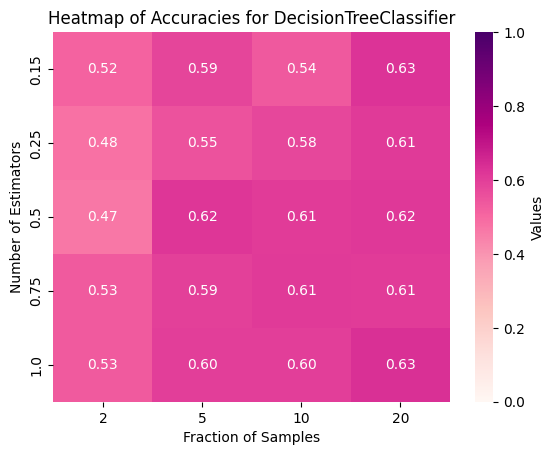

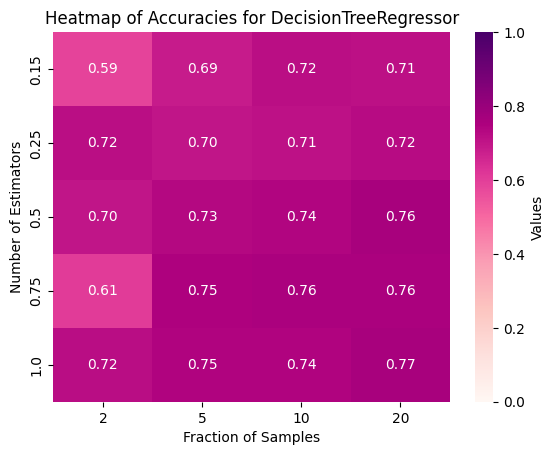

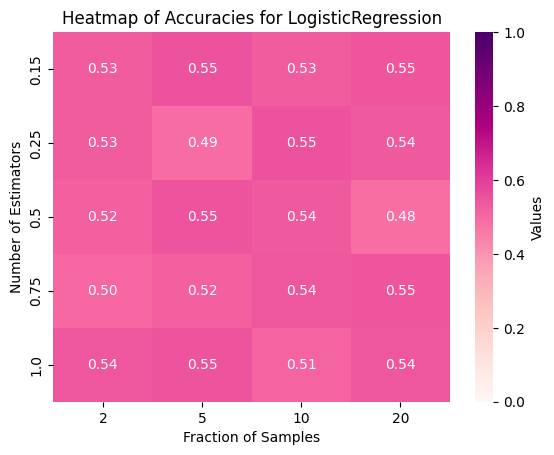

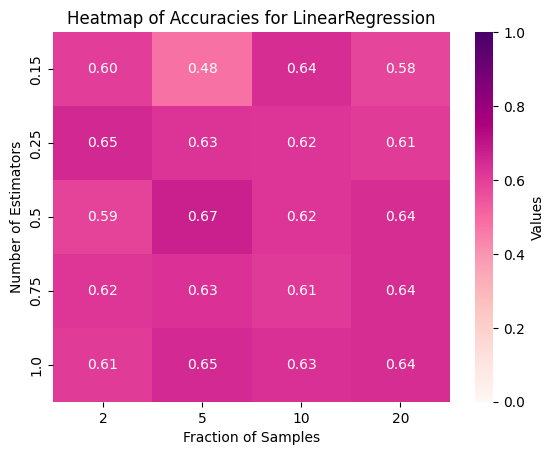

In [277]:
plotheatmap(accuracies_bagging_dt_classifier, 'DecisionTreeClassifier')
plotheatmap(accuracies_bagging_dt_regressor, 'DecisionTreeRegressor')
plotheatmap(accuracies_bagging_logreg, 'LogisticRegression')
plotheatmap(accuracies_bagging_linreg, 'LinearRegression')
if mlp:
    plotheatmap(accuracies_bagging_mlp_classifier, 'MLPClassifier')
    plotheatmap(accuracies_bagging_mlp_regressor, 'MLPRegressor')

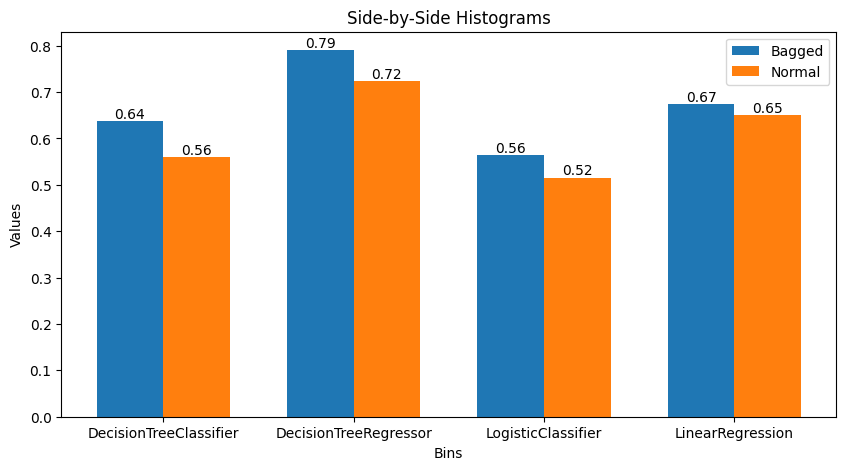

In [310]:
bins = ['DecisionTreeClassifier', 'DecisionTreeRegressor', 'LogisticClassifier', 'LinearRegression']
best_accuracies_bagged = [
    best_params_bagging_dt_classifier[-1],
    best_params_bagging_dt_regressor[-1],
    best_params_bagging_logreg[-1],
    best_params_bagging_linreg[-1]
]
best_accuracy_normal = [
    accuracy_score(wine_y_test, dt_classifier.predict(wine_X_test)),
    r2_score(housing_y_test, dt_regressor.predict(housing_X_test)),
    accuracy_score(wine_y_test, logreg.predict(wine_X_test)),
    r2_score(housing_y_test, linreg.predict(housing_X_test))
]

if mlp:
    bins.extend(['MLPClassifier', 'MLPRegressor'])
    best_accuracies_bagged.extend([
        best_params_bagging_mlp_classifier[-1],
        best_params_bagging_mlp_regressor[-1]
    ])
    best_accuracy_normal.extend([
        mlp_classifier.evaluate(wine_X_test, wine_y_test),
        mlp_regressor.evaluate(housing_X_test, housing_y_test)
    ])

# Using Chat-GPT
fig, ax = plt.subplots(figsize=(10, 5))
width = 0.35
ind = np.arange(len(bins))  # the x locations for the groups

rects1 = ax.bar(ind - width/2, best_accuracies_bagged, width, label='Bagged')
rects2 = ax.bar(ind + width/2, best_accuracy_normal, width, label='Normal')

for i, rect in enumerate(rects1):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % best_accuracies_bagged[i],
            ha='center', va='bottom')

for i, rect in enumerate(rects2):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % best_accuracy_normal[i],
            ha='center', va='bottom')

ax.set_xlabel('Bins')
ax.set_ylabel('Values')
ax.set_title('Side-by-Side Histograms')
ax.set_xticks(ind)
ax.set_xticklabels(bins)
ax.legend()

plt.show()

#### Stacking

In [472]:
stacking_classifier = Stacking([dt_classifier, logreg], DecisionTreeClassifier, best_params_dt_classifier, method='stacking', n_fold=3, classification=True)
# stacking_classifier.fit(housing_X_train, housing_y_train)
# stacking_classifier.evaluate(housing_X_test, housing_y_test)
stacking_classifier.fit(wine_X_train, wine_y_train)
stacking_classifier.evaluate(wine_X_test, wine_y_test)

0.5938864628820961

In [478]:
models_classifier = [dt_classifier, logreg]
models_regressor = [dt_regressor, linreg]

if mlp:
    models_classifier.append(mlp_classifier)
    models_regressor.append(mlp_regressor)

best_hyperparameter_classifier = {
    'method': None,
    'n_fold': None,
    'level1_model': None,
    'level1_params': None,
    'accuracy': -np.inf
}
best_hyperparameter_regressor = {
    'method': None,
    'n_fold': None,
    'level1_model': None,
    'level1_params': None,
    'accuracy': -np.inf
}

In [481]:
for method in ['stacking', 'blending']:
    for n_fold in [3,5,7]:
        stacking_classifier = Stacking(models_classifier, DecisionTreeClassifier, best_params_dt_classifier, method=method, n_fold=n_fold, classification=True)
        stacking_classifier.fit(wine_X_train, wine_y_train)
        accuracy = stacking_dt_classifier.evaluate(wine_X_test, wine_y_test)

        if accuracy > best_hyperparameter_classifier['accuracy']:
            best_hyperparameter_classifier = {
                'method': method,
                'n_fold': n_fold,
                'level1_model': 'DecisionTreeClassifier',
                'level1_params': best_params_dt_classifier,
                'accuracy': accuracy
            }
        
        stacking_classifier = Stacking(models_classifier, Logistic_Regression, best_params_logistic, method=method, n_fold=n_fold, classification=True)
        stacking_classifier.fit(wine_X_train, wine_y_train)
        accuracy = stacking_classifier.evaluate(wine_X_test, wine_y_test)

        if accuracy > best_hyperparameter_classifier['accuracy']:
            best_hyperparameter_classifier = {
                'method': method,
                'n_fold': n_fold,
                'level1_model': 'LogisticRegression',
                'level1_params': best_params_logistic,
                'accuracy': accuracy
            }
        
        stacking_regressor = Stacking(models_regressor, DecisionTreeRegressor, best_params_dt_regressor, method=method, n_fold=n_fold, classification=False)
        stacking_regressor.fit(housing_X_train, housing_y_train)
        accuracy = stacking_regressor.evaluate(housing_X_test, housing_y_test)

        if accuracy > best_hyperparameter_regressor['accuracy']:
            best_hyperparameter_regressor = {
                'method': method,
                'n_fold': n_fold,
                'level1_model': 'DecisionTreeRegressor',
                'level1_params': best_params_dt_regressor,
                'accuracy': accuracy
            }
        
        stacking_regressor = Stacking(models_regressor, Linear_Regression, best_params_linreg, method=method, n_fold=n_fold, classification=False)
        stacking_regressor.fit(housing_X_train, housing_y_train)
        accuracy = stacking_regressor.evaluate(housing_X_test, housing_y_test)

        if accuracy > best_hyperparameter_regressor['accuracy']:
            best_hyperparameter_regressor = {
                'method': method,
                'n_fold': n_fold,
                'level1_model': 'LinearRegression',
                'level1_params': best_params_linreg,
                'accuracy': accuracy
            }

/tmp/ipykernel_36778/1096722987.py:44: RuntimeWarning: overflow encountered in square
  return np.mean(np.square(y_true - y_pred))
/tmp/ipykernel_36778/1096722987.py:25: RuntimeWarning: invalid value encountered in subtract
  self.weights -= self.learning_rate * dw
/tmp/ipykernel_36778/1096722987.py:44: RuntimeWarning: overflow encountered in square
  return np.mean(np.square(y_true - y_pred))
/tmp/ipykernel_36778/1096722987.py:44: RuntimeWarning: overflow encountered in square
  return np.mean(np.square(y_true - y_pred))
/home/bhavb/.local/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_36778/1096722987.py:44: RuntimeWarning: overflow encountered in square
  return np.mean(np.square(y_true - y_pred))
/home/bhavb/.local/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype,

In [482]:
print(f"Best hyperparameter for stacking classifier: {best_hyperparameter_classifier}")
print(f"Best hyperparameter for stacking regressor: {best_hyperparameter_regressor}")

Best hyperparameter for stacking classifier: {'method': 'stacking', 'n_fold': 3, 'level1_model': 'DecisionTreeClassifier', 'level1_params': {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}, 'accuracy': 0.5938864628820961}
Best hyperparameter for stacking regressor: {'method': 'stacking', 'n_fold': 7, 'level1_model': 'DecisionTreeRegressor', 'level1_params': {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}, 'accuracy': 0.809541609449077}


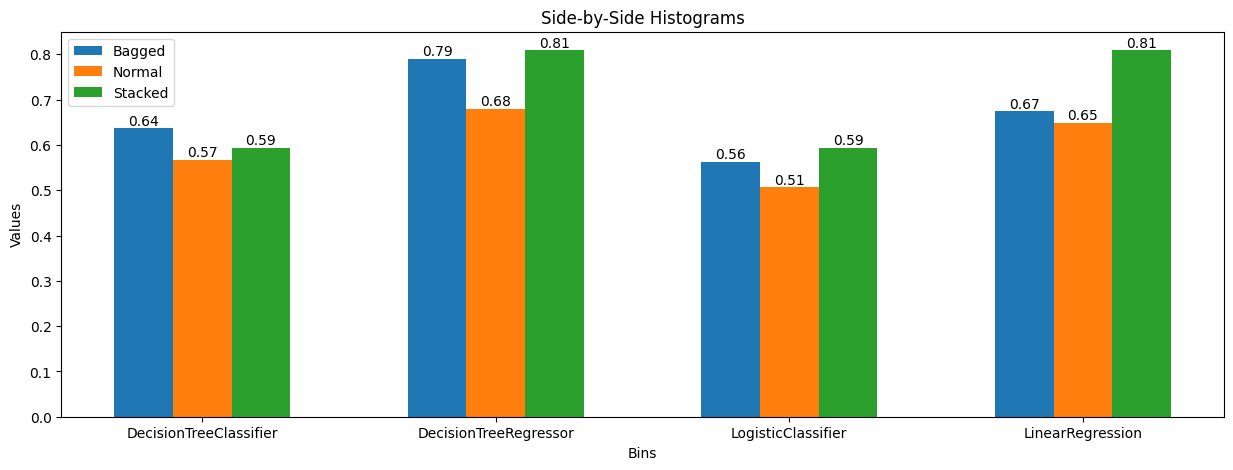

In [498]:
bins = ['DecisionTreeClassifier', 'DecisionTreeRegressor', 'LogisticClassifier', 'LinearRegression']
best_accuracies_bagged = [
    best_params_bagging_dt_classifier[-1],
    best_params_bagging_dt_regressor[-1],
    best_params_bagging_logreg[-1],
    best_params_bagging_linreg[-1]
]
best_accuracy_normal = [
    accuracy_score(wine_y_test, dt_classifier.predict(wine_X_test)),
    r2_score(housing_y_test, dt_regressor.predict(housing_X_test)),
    accuracy_score(wine_y_test, logreg.predict(wine_X_test)),
    r2_score(housing_y_test, linreg.predict(housing_X_test))
]
best_accuracies_stack = [
    best_hyperparameter_classifier['accuracy'],
    best_hyperparameter_regressor['accuracy'],
    best_hyperparameter_classifier['accuracy'],
    best_hyperparameter_regressor['accuracy']
]

if mlp:
    bins.extend(['MLPClassifier', 'MLPRegressor'])
    best_accuracies_bagged.extend([
        best_params_bagging_mlp_classifier[-1],
        best_params_bagging_mlp_regressor[-1]
    ])
    best_accuracy_normal.extend([
        mlp_classifier.evaluate(wine_X_test, wine_y_test),
        mlp_regressor.evaluate(housing_X_test, housing_y_test)
    ])
    best_accuracies_stack.extend([
        best_hyperparameter_classifier['accuracy'],
        best_hyperparameter_regressor['accuracy']
    ])

# Using Chat-GPT
fig, ax = plt.subplots(figsize=(15, 5))
width = 0.2
ind = np.arange(len(bins))  # the x locations for the groups

rects1 = ax.bar(ind - width, best_accuracies_bagged, width, label='Bagged')
rects2 = ax.bar(ind, best_accuracy_normal, width, label='Normal')
rects3 = ax.bar(ind + width, best_accuracies_stack, width, label='Stacked')

for i, rect in enumerate(rects1):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % best_accuracies_bagged[i],
            ha='center', va='bottom')

for i, rect in enumerate(rects2):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % best_accuracy_normal[i],
            ha='center', va='bottom')

for i, rect in enumerate(rects3):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % best_accuracies_stack[i],
            ha='center', va='bottom')

ax.set_xlabel('Bins')
ax.set_ylabel('Values')
ax.set_title('Side-by-Side Histograms')
ax.set_xticks(ind)
ax.set_xticklabels(bins)
ax.legend()

plt.show()

#### Random Forest

In [84]:
best_params_rf_classifier = 0
best_accuracy_rf_classifier = -np.inf
best_params_rf_regressor = 0
best_accuracy_rf_regressor = -np.inf

In [90]:
for n_estimators in [2,5,10,20,30]:
    model = RandomForest(best_params_dt_classifier, n_estimators=n_estimators, classification=True)
    model.fit(wine_X_train, wine_y_train, wine_X_val, wine_y_val)
    accuracy = model.evaluate(wine_X_test, wine_y_test)

    if accuracy > best_accuracy_rf_classifier:
        best_accuracy_rf_classifier = accuracy
        best_params_rf_classifier = {'n_estimators': n_estimators, 'best_params': best_params_dt_classifier}
    
    model = RandomForest(best_params_dt_regressor, n_estimators=n_estimators, classification=False)
    model.fit(housing_X_train, housing_y_train, housing_X_val, housing_y_val)
    accuracy = model.evaluate(housing_X_test, housing_y_test)

    if accuracy > best_accuracy_rf_regressor:
        best_accuracy_rf_regressor = accuracy
        best_params_rf_regressor = {'n_estimators': n_estimators, 'best_params': best_params_dt_regressor}

print(f"Best n_estimators for RandomForestClassifier: {best_params_rf_classifier}")
print(f"Accuracy for RandomForestClassifier: {best_accuracy_rf_classifier}")
print(f"Best n_estimators for RandomForestRegressor: {best_params_rf_regressor}")  
print(f"Accuracy for RandomForestRegressor: {best_accuracy_rf_regressor}") 

Best n_estimators for RandomForestClassifier: {'n_estimators': 20, 'best_params': {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}}
Accuracy for RandomForestClassifier: 0.6462882096069869
Best n_estimators for RandomForestRegressor: {'n_estimators': 5, 'best_params': {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}}
Accuracy for RandomForestRegressor: 0.8140196289284751


#### AdaBoost

In [79]:
wine_y_test1 = np.array([0 if y < 5 else 1 for y in wine_y_test])
wine_y_train1 = np.array([0 if y < 5 else 1 for y in wine_y_train])
wine_y_val1 = np.array([0 if y < 5 else 1 for y in wine_y_val])

best_params_dt_classifier1 = best_params_dt_classifier.copy()
best_params_dt_classifier1['max_depth'] -= 1

In [80]:
no_estimators = [2,5,10,15,20,25,30]
accuracy_adaboost_classifier = []
time_adaboost_classifier = []
accuracy_adaboost_regressor = []
time_adaboost_regressor = []

In [81]:
for no_estimator in no_estimators:
    start_time = time.time()
    adaboost_classifier = AdaBoostClassifier(T=no_estimator, best_params=best_params_dt_classifier1)
    adaboost_classifier.fit(wine_X_train, wine_y_train1)
    accuracy = adaboost_classifier.evaluate(wine_X_test, wine_y_test1)
    end_time = time.time()

    accuracy_adaboost_classifier.append(accuracy)
    time_adaboost_classifier.append(end_time-start_time)

    start_time = time.time()
    adaboost_regressor = AdaBoostRegressor(T=no_estimator, best_params=best_params_dt_regressor)
    adaboost_regressor.fit(housing_X_train, housing_y_train)
    accuracy = adaboost_regressor.evaluate(housing_X_test, housing_y_test)
    end_time = time.time()

    accuracy_adaboost_regressor.append(accuracy)
    time_adaboost_regressor.append(end_time-start_time)

best_index = np.argmax(accuracy_adaboost_classifier)
best_accuracy_adaboost_classifier = accuracy_adaboost_classifier[best_index]
best_no_estimator_adaboost_classifier = no_estimators[best_index]

best_index = np.argmax(accuracy_adaboost_regressor)
best_accuracy_adaboost_regressor = accuracy_adaboost_regressor[best_index]
best_no_estimator_adaboost_regressor = no_estimators[best_index]

Best no. of estimators for AdaBoostClassifier: 10
Best accuracy for AdaBoostClassifier: 0.9737991266375546


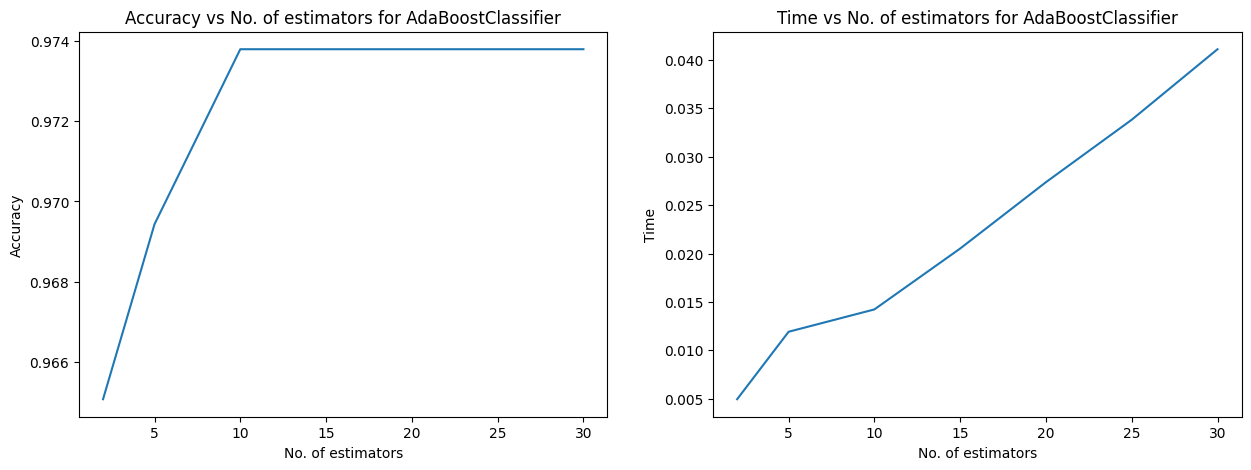

In [82]:
print(f"Best no. of estimators for AdaBoostClassifier: {best_no_estimator_adaboost_classifier}")
print(f"Best accuracy for AdaBoostClassifier: {best_accuracy_adaboost_classifier}")

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(no_estimators, accuracy_adaboost_classifier)
plt.xlabel('No. of estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs No. of estimators for AdaBoostClassifier')

plt.subplot(1,2,2)
plt.plot(no_estimators, time_adaboost_classifier)
plt.xlabel('No. of estimators')
plt.ylabel('Time')
plt.title('Time vs No. of estimators for AdaBoostClassifier')
plt.show()

Best no. of estimators for AdaBoostRegressor: 25
Best score for AdaBoostRegressor: 0.8864388650336998


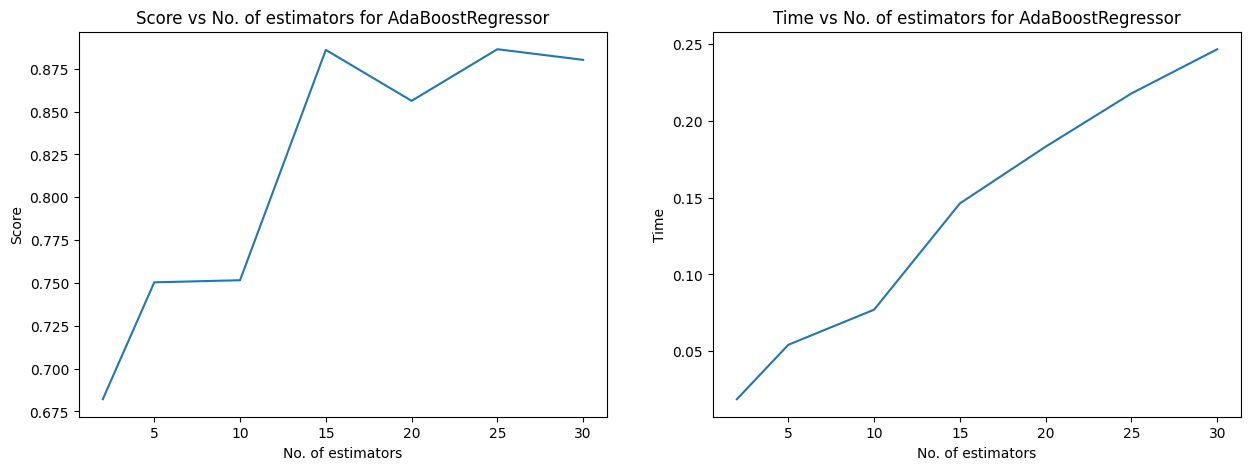

In [83]:
print(f"Best no. of estimators for AdaBoostRegressor: {best_no_estimator_adaboost_regressor}")
print(f"Best score for AdaBoostRegressor: {best_accuracy_adaboost_regressor}")

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(no_estimators, accuracy_adaboost_regressor)
plt.xlabel('No. of estimators')
plt.ylabel('Score')
plt.title('Score vs No. of estimators for AdaBoostRegressor')

plt.subplot(1,2,2)
plt.plot(no_estimators, time_adaboost_regressor)
plt.xlabel('No. of estimators')
plt.ylabel('Time')
plt.title('Time vs No. of estimators for AdaBoostRegressor')
plt.show()

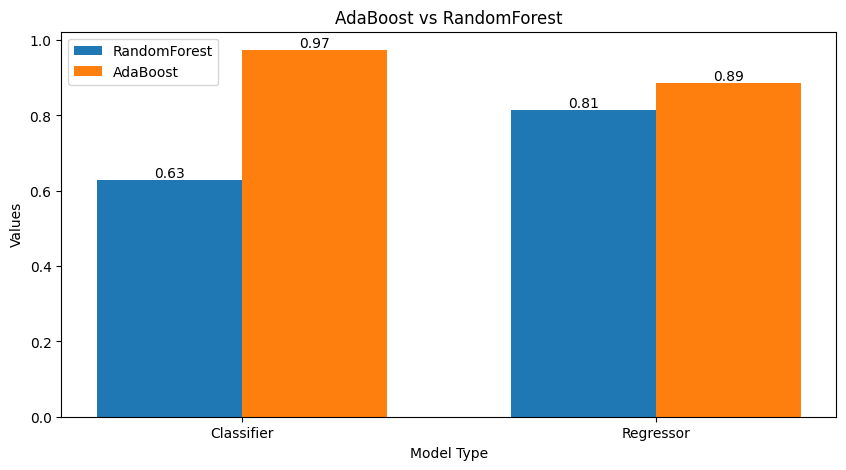

In [89]:
# Plot side-by-side accuracy for Random Forest and AdaBoost for Classification and Regression

bins = ['Classifier', 'Regressor']
best_accuracies_rf = [
    best_accuracy_rf_classifier,
    best_accuracy_rf_regressor
]
best_accuracies_adaboost = [
    best_accuracy_adaboost_classifier,
    best_accuracy_adaboost_regressor
]

# Using Chat-GPT
fig, ax = plt.subplots(figsize=(10, 5))
width = 0.35
ind = np.arange(len(bins))  # the x locations for the groups

rects1 = ax.bar(ind - width/2, best_accuracies_rf, width, label='RandomForest')
rects2 = ax.bar(ind + width/2, best_accuracies_adaboost, width, label='AdaBoost')

for i, rect in enumerate(rects1):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % best_accuracies_rf[i],
            ha='center', va='bottom')

for i, rect in enumerate(rects2):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % best_accuracies_adaboost[i],
            ha='center', va='bottom')

ax.set_xlabel('Model Type')
ax.set_ylabel('Values')
ax.set_title('AdaBoost vs RandomForest')
ax.set_xticks(ind)
ax.set_xticklabels(bins)
ax.legend()

plt.show()

#### Gradient Boosting